# Detect Malignant Tumors - A Machine Learning Project 

---
## Introduction
kaggel dataset url: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data


### TLDR Version

This dataset contains information on 569 breast tumors and the mean, standard error and worst measures for 10 different properties. I start with an EDA analysing each properties' distribution, followed by the pair interactions and then the correlations with our target: the tumor diagnosis.

After the EDA I set up 10 out-of-the-box models for a first evaluation and use cross-validation to measure them. I use Recall instead of Accuracy or F1-Score since I want to detect all malignant tumors. After the first results I analyse features importances, do a single round of feature selection and evaluate the models again. By the end of the chapter I analyse model errors and from the 10 first models I choose 5 for model tuning: Logistic Regression, SVC, Random Forest, Gradient Boosting and KNN.

I then proceed to tune the five models using GridSearchCV and prepare the data for model stacking by predicting probabilities for both train and test sets. Using Logistic Regression as a second-level model, I tune its parameters and finish the construction phase.

Finally, I test all first level models and the stacked Logistic Regression on our untouched test-set. For the first level models, using regular 0.5 threshold Logistic Regression performed best with 95,8% Recall. By lowering the threshold SVC and Logistic Regression tied with over 98% recall with SVC having a higher Accuracy. By using the model-stacking technique, Logistic Regression was able to obtain 100% Recall on the test set. On the last chapter I summarize the findings and conclusions.

On Annex - A I repeat a few Machine Learning steps using SMOTE to generate new data points making the data balanced. 

On Annex - B I use three different dimensionality reduction techniques to see if I can reduce the dataset and still get a good test score.

---

---

# 1 - The Dataset
---
## 1.1 - Introducing the Data

### General Information
- Original format: csv
- Dataset shape: 569 x 33 (rows x columns)
- Granularity: Each row derives from an unique sample of breast mass
- There are no null values in this data.
- The values are in different scales

### Features in the dataset
For each sample ten properties were measured:

<ol>
    <li><b>Radius</b> - Mean distances from center to points on the perimeter</li>
    <li><b>Texture</b> - Standard deviation of gray scale values</li>
    <li><b>Perimeter</b></li>
    <li><b>Area</b></li>
    <li><b>Smoothness</b> - Local variation in radius lengths</li>
    <li><b>Compactness</b> - Perimeter^2/Area - 1</li>
    <li><b>Concavity</b> - Severity of concave portions of the contour</li>
    <li><b>Concave points</b> - Number of concave portions of the contour</li>
    <li><b>Simmetry</b></li>
    <li><b>Fractal Dimension</b> - Coastline approximation - 1 </li>
</ol>

<blockquote>
    <font color='darkblue'>
        <b>From <a href="https://en.wikipedia.org/wiki/Fractal_dimension">wikipedia</a>:</b>
        <br><i>[...] a <b>fractal dimension</b> is a ratio providing a statistical index of complexity comparing how detail in a pattern (strictly speaking, a fractal pattern) changes with the scale at which it is measured.</i>
    </font>
    </blockquote>
    
And for each of these properties we have three calculated values:
- **Mean**
- **Standard Error**
- **Worst** (Average of the 3 largest values)

All the measures are float types.

### Target
Our target is the categorical column *diagnosis* with either B (benign) or M (malignant).<br>
There are 357 benign classes and 212 malignant classes - roughly **37% malignant tumors**.

<hr/>

---

## 1.2 -  Importing Libraries

We need only the basic tools for an EDA for now.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', rc={'axes.grid': False})

In [2]:
dataset = pd.read_csv('data.csv')
dataset.sample(5)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
554  924632         B       12.880         28.92           82.50      514.3   
179  873586         B       12.810         13.06           81.29      508.8   
538  921092         B        7.729         25.49           47.98      178.8   
249  884689         B       11.520         14.93           73.87      406.3   
482  912519         B       13.470         14.06           87.32      546.3   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
554          0.08123           0.05824        0.061950              0.02343   
179          0.08739           0.03774        0.009193              0.01330   
538          0.08098           0.04878        0.000000              0.00000   
249          0.10130           0.07808        0.043280              0.02929   
482          0.10710           0.11550        0.057860              0.05266   

        ...       texture_worst  perimeter_worst  area_worst  \
554     ...               35.74            88.84       595.7   
179     ...               16.15            86.70       570.7   
538     ...               30.92            57.17       248.0   
249     ...               21.19            80.88       491.8   
482     ...               18.32            94.94       660.2   

     smoothness_worst  compactness_worst  concavity_worst  \
554            0.1227            0.16200          0.24390   
179            0.1162            0.05445          0.02758   
538            0.1256            0.08340          0.00000   
249            0.1389            0.15820          0.18040   
482            0.1393            0.24990          0.18480   

     concave points_worst  symmetry_worst  fractal_dimension_worst  \
554               0.06493          0.2372                  0.07242   
179               0.03990          0.1783                  0.07319   
538               0.00000          0.3058                  0.09938   
249               0.09608          0.2664                  0.07809   
482               0.13350          0.3227                  0.09326   

     Unnamed: 32  
554          NaN  
179          NaN  
538          NaN  
249          NaN  
482          NaN  

[5 rows x 33 columns]

In [3]:
# Our last column is just an error in the data reading. Dropping it
dataset = dataset.drop(['id', 'Unnamed: 32'], axis=1)

# Creating a binary target column to allow some data manipulations later on
dataset['Target'] = dataset['diagnosis'].map({'B':0, 'M':1})

# Getting lists with features. This will be useful on visualization
mean_feats = np.concatenate([['diagnosis'], dataset.iloc[:,1:11].columns.tolist()])
error_feats = np.concatenate([['diagnosis'], dataset.iloc[:,11:21].columns.tolist()])
worst_feats = np.concatenate([['diagnosis'], dataset.iloc[:,21:31].columns.tolist()])

<hr>

## 1.3 - Defining Train/Test sets

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.3,
                               stratify=dataset['Target'], random_state=42) 

Using the stratify parameter we can guarantee that both our train and test sets have the same proportion of both classes. We must make sure our train data is as close as possible to the data it is going to be evaluated on.

In [5]:
train_diag = train.diagnosis.value_counts() / train.shape[0]
train_diag.rename('Train', inplace=True)
test_diag = test.diagnosis.value_counts() / test.shape[0]
test_diag.rename('Test', inplace=True)

pd.concat([train_diag, test_diag], axis=1)

Train      Test
B  0.628141  0.625731
M  0.371859  0.374269

<hr/>

<hr>

# 2 - Exploratory Data Analysis
Now we will look at individual features and combinations of features

<hr>

## 2.1 - Data Distributions

We are dealing with three measures: mean, std. error and the 'worst'. We should look at each separatedly.



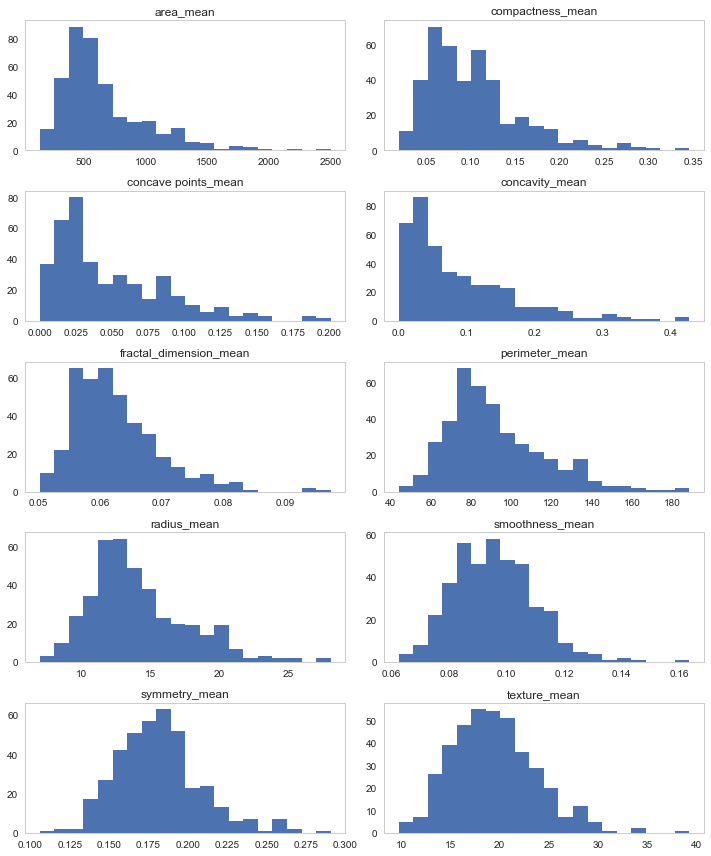

In [6]:
train.iloc[:,1:11].hist(figsize=(10,12), bins=20, layout=(5,2), grid=False)
plt.tight_layout();

We can see that some features are pretty skewed. We can measure its skewness using pandas *skew* method and we can try comparing it to a log transformation of the same values to see if we can reduce the skewness.

In [7]:
log_means = np.log1p(train.iloc[:,1:11])

skewness = pd.DataFrame({'Original Skewness':train.iloc[:,1:11].skew(),
                         'Log Transformed':log_means.skew()})
skewness['Skewness Reduction'] = skewness['Original Skewness'] - skewness['Log Transformed']
skewness

Original Skewness  Log Transformed  Skewness Reduction
radius_mean                      0.957984         0.341400            0.616583
texture_mean                     0.646057        -0.026770            0.672828
perimeter_mean                   1.003896         0.315615            0.688281
area_mean                        1.637987         0.268267            1.369719
smoothness_mean                  0.603007         0.550194            0.052813
compactness_mean                 1.314372         1.151288            0.163084
concavity_mean                   1.481724         1.274931            0.206793
concave points_mean              1.223607         1.129755            0.093852
symmetry_mean                    0.688502         0.602852            0.085650
fractal_dimension_mean           1.315506         1.284973            0.030532

We managed to greatly reduce skewness on **Radius, Texture, Perimeter and Area**. The other features were barely influenced by our log transformation. 

There are four features with skewness higher than one after the log transformation: **Compactness, Concavity, Concave Points and Fractal Dimension**. Perhaps the measure error on them is higher or maybe it is somehow biased. Let's explore how are the standard errors for each measure!

In [8]:
measure_index = ['radius', 'texture', 'perimeter', 'area',
                'smoothness', 'compactness', 'concavity',
                'concave points', 'symmetry', 'fractal_dimension']

measure_data = np.c_[train.iloc[:,1:11].mean().values, train.iloc[:,11:21].mean().values]

measure_df = pd.DataFrame(data=measure_data, columns=['Mean', 'Error'], index=measure_index)

measure_df['Error pct'] = 100 * measure_df['Error'] / measure_df['Mean']

measure_df

Mean      Error  Error pct
radius              14.126503   0.406775   2.879519
texture             19.438241   1.217377   6.262793
perimeter           91.904422   2.867628   3.120229
area               655.325377  40.296108   6.149023
smoothness           0.095857   0.006924   7.223479
compactness          0.102648   0.025142  24.493824
concavity            0.088497   0.032268  36.462107
concave points       0.048535   0.011583  23.864573
symmetry             0.181364   0.020421  11.259927
fractal_dimension    0.062620   0.003761   6.006799

This might explain part of our high skewness: from our four highly skewed features, three of them have standard errors of more than 20%! 



<hr>

## 2.2 - Features Overlook 
We can use seaborn's amazing pairplot to give a first overview on all features and some pair interactions. 

### Mean Features Plot

There are a few things to point out on this plot.
- From all the histograms in the grid's diagonal plots, only fractal dimension has no visual impact on the tumor's class. That is also observed in all plots on the last row/column. This is convenient because Fractal Dimension is the unexplained skewed feature we've just talked about. This is a strong candidate for a feature selection later on.
- The second lowest visual impact (I'm saying visual because we will see some numbers later) is on symmetry.  
- All the other features appear to have a significant impact on the classification of tumors and the scatterplots look quite 'separable'. 


In [9]:
sns.set(style='whitegrid', font_scale=1.35, rc={'axes.grid': False})

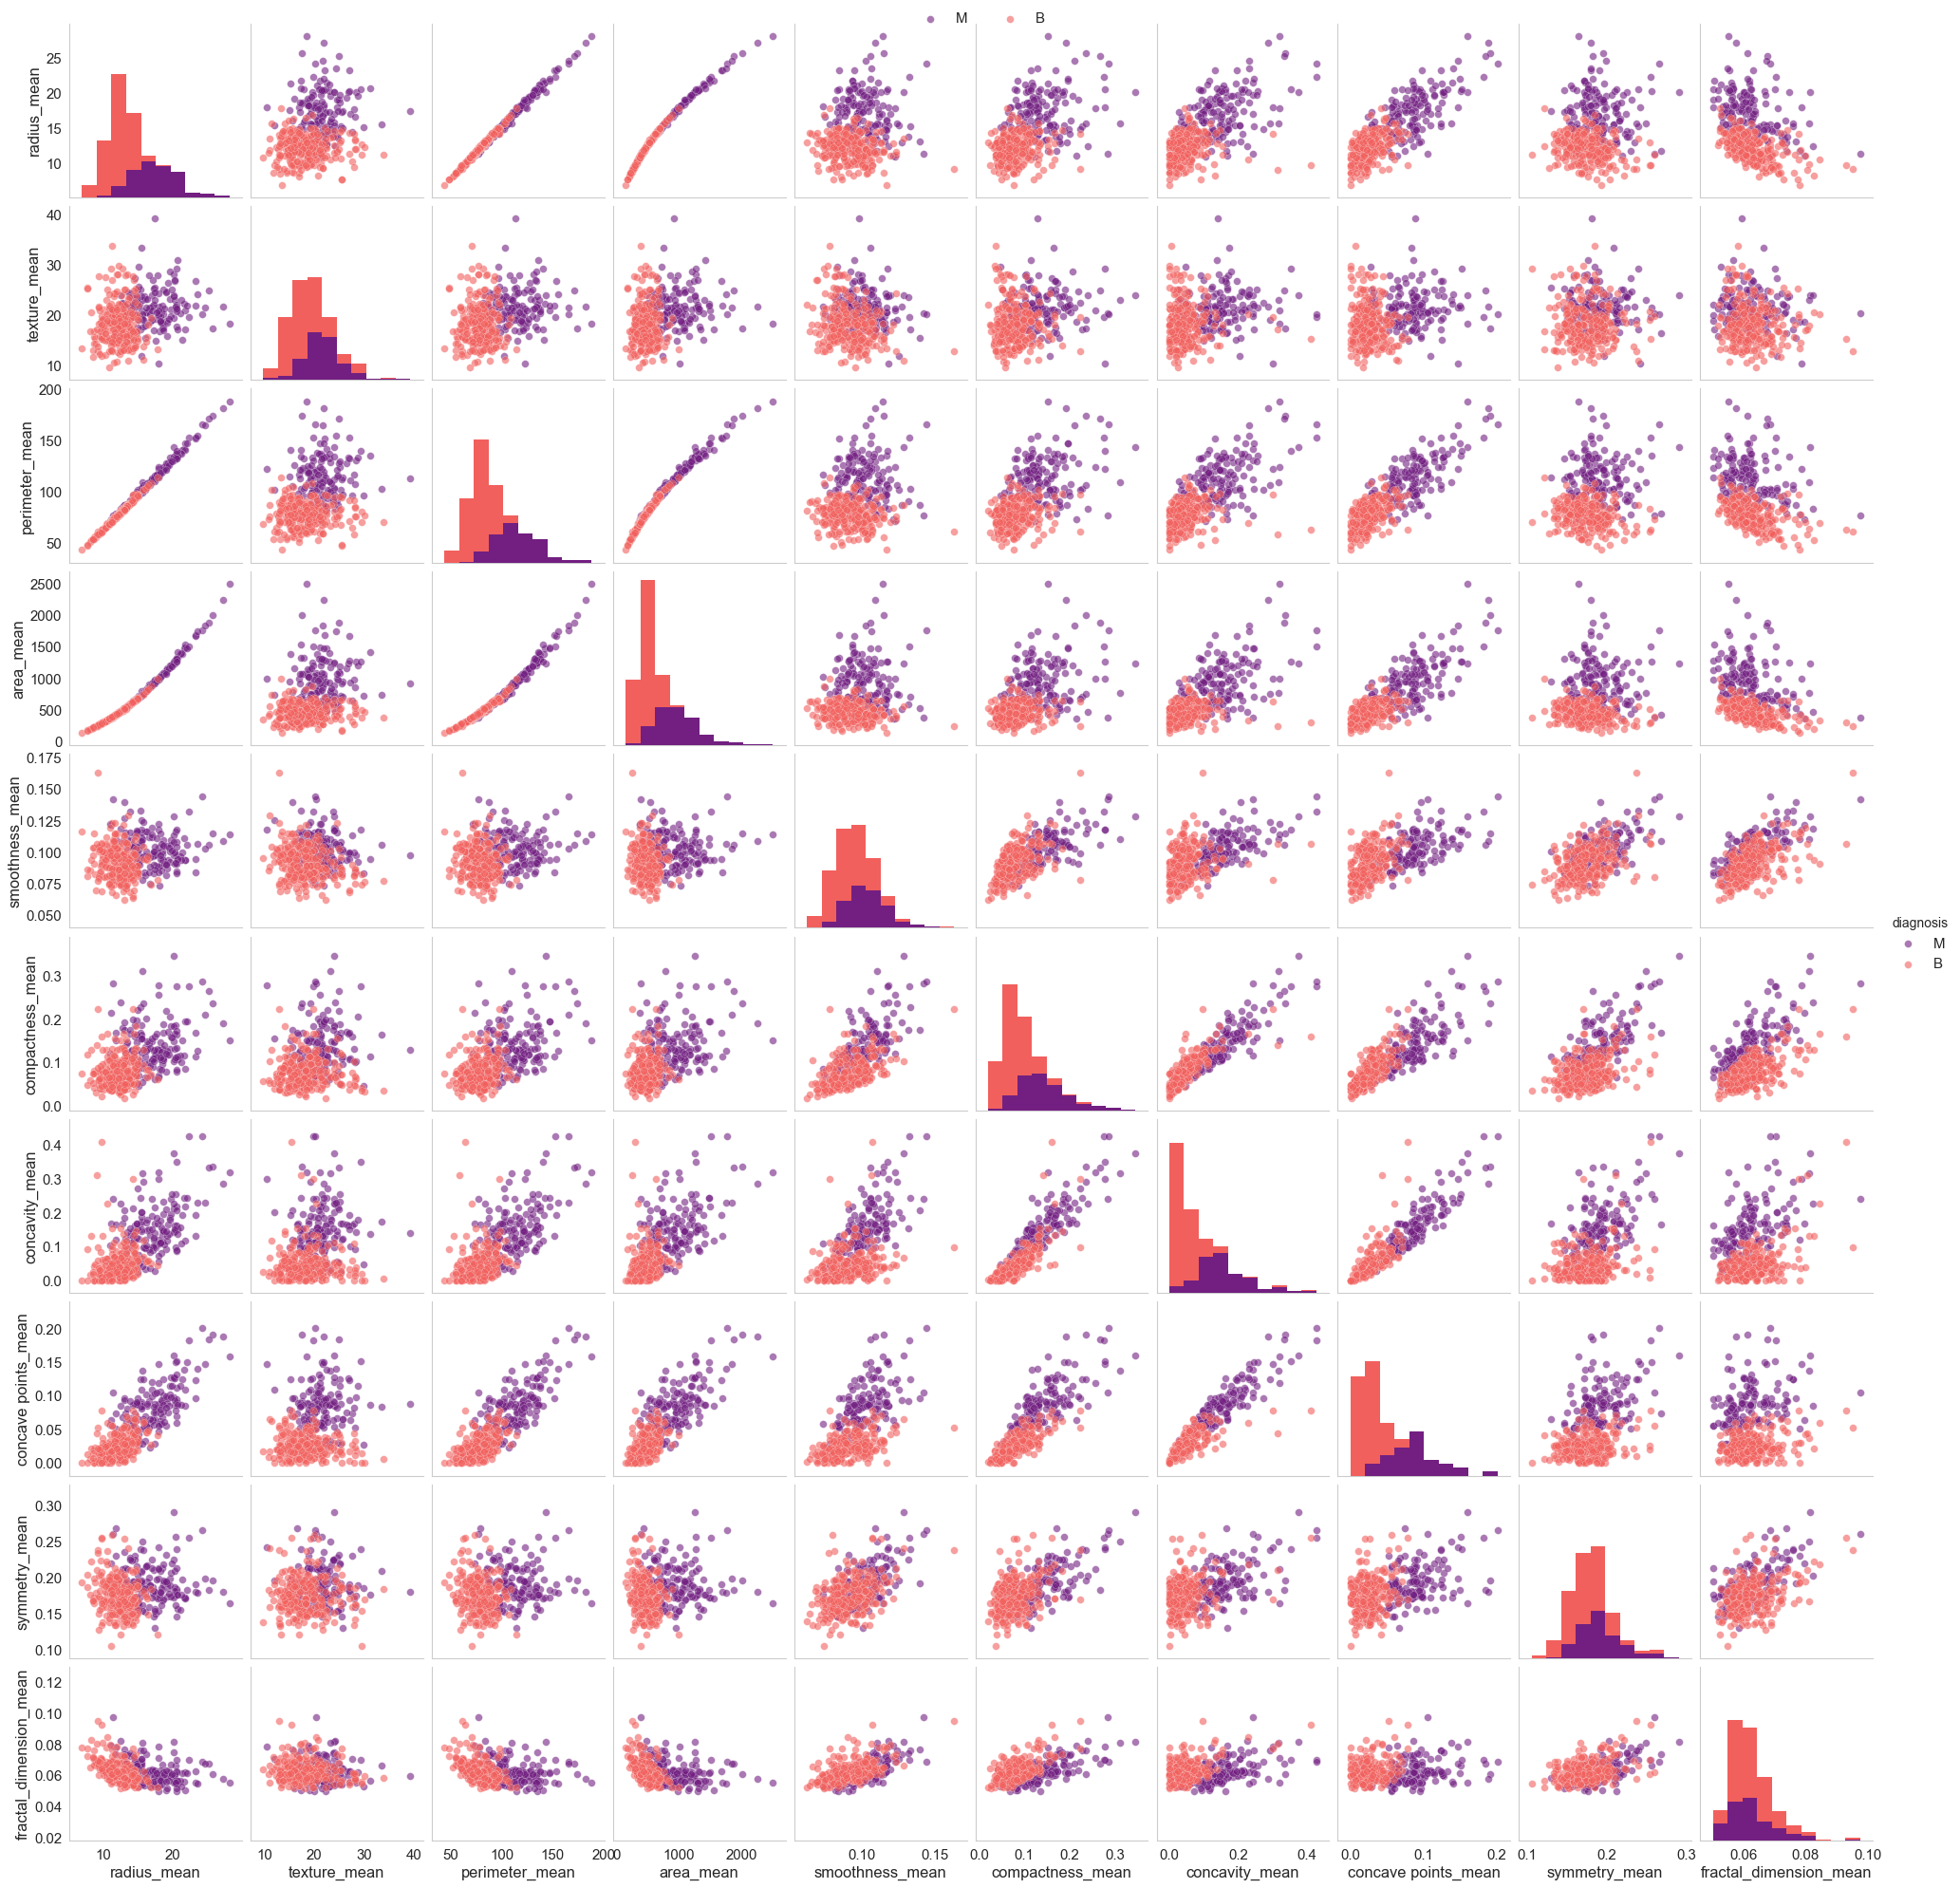

In [10]:
p = sns.pairplot(train[mean_feats], hue='diagnosis',
             plot_kws={'alpha':0.6}, palette='magma')

plt.subplots_adjust(hspace=0.05, wspace=0.05)
handles = p._legend_data.values()
labels = p._legend_data.keys()
p.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=2)
p.fig.set_dpi(80);

### Error Features Plot


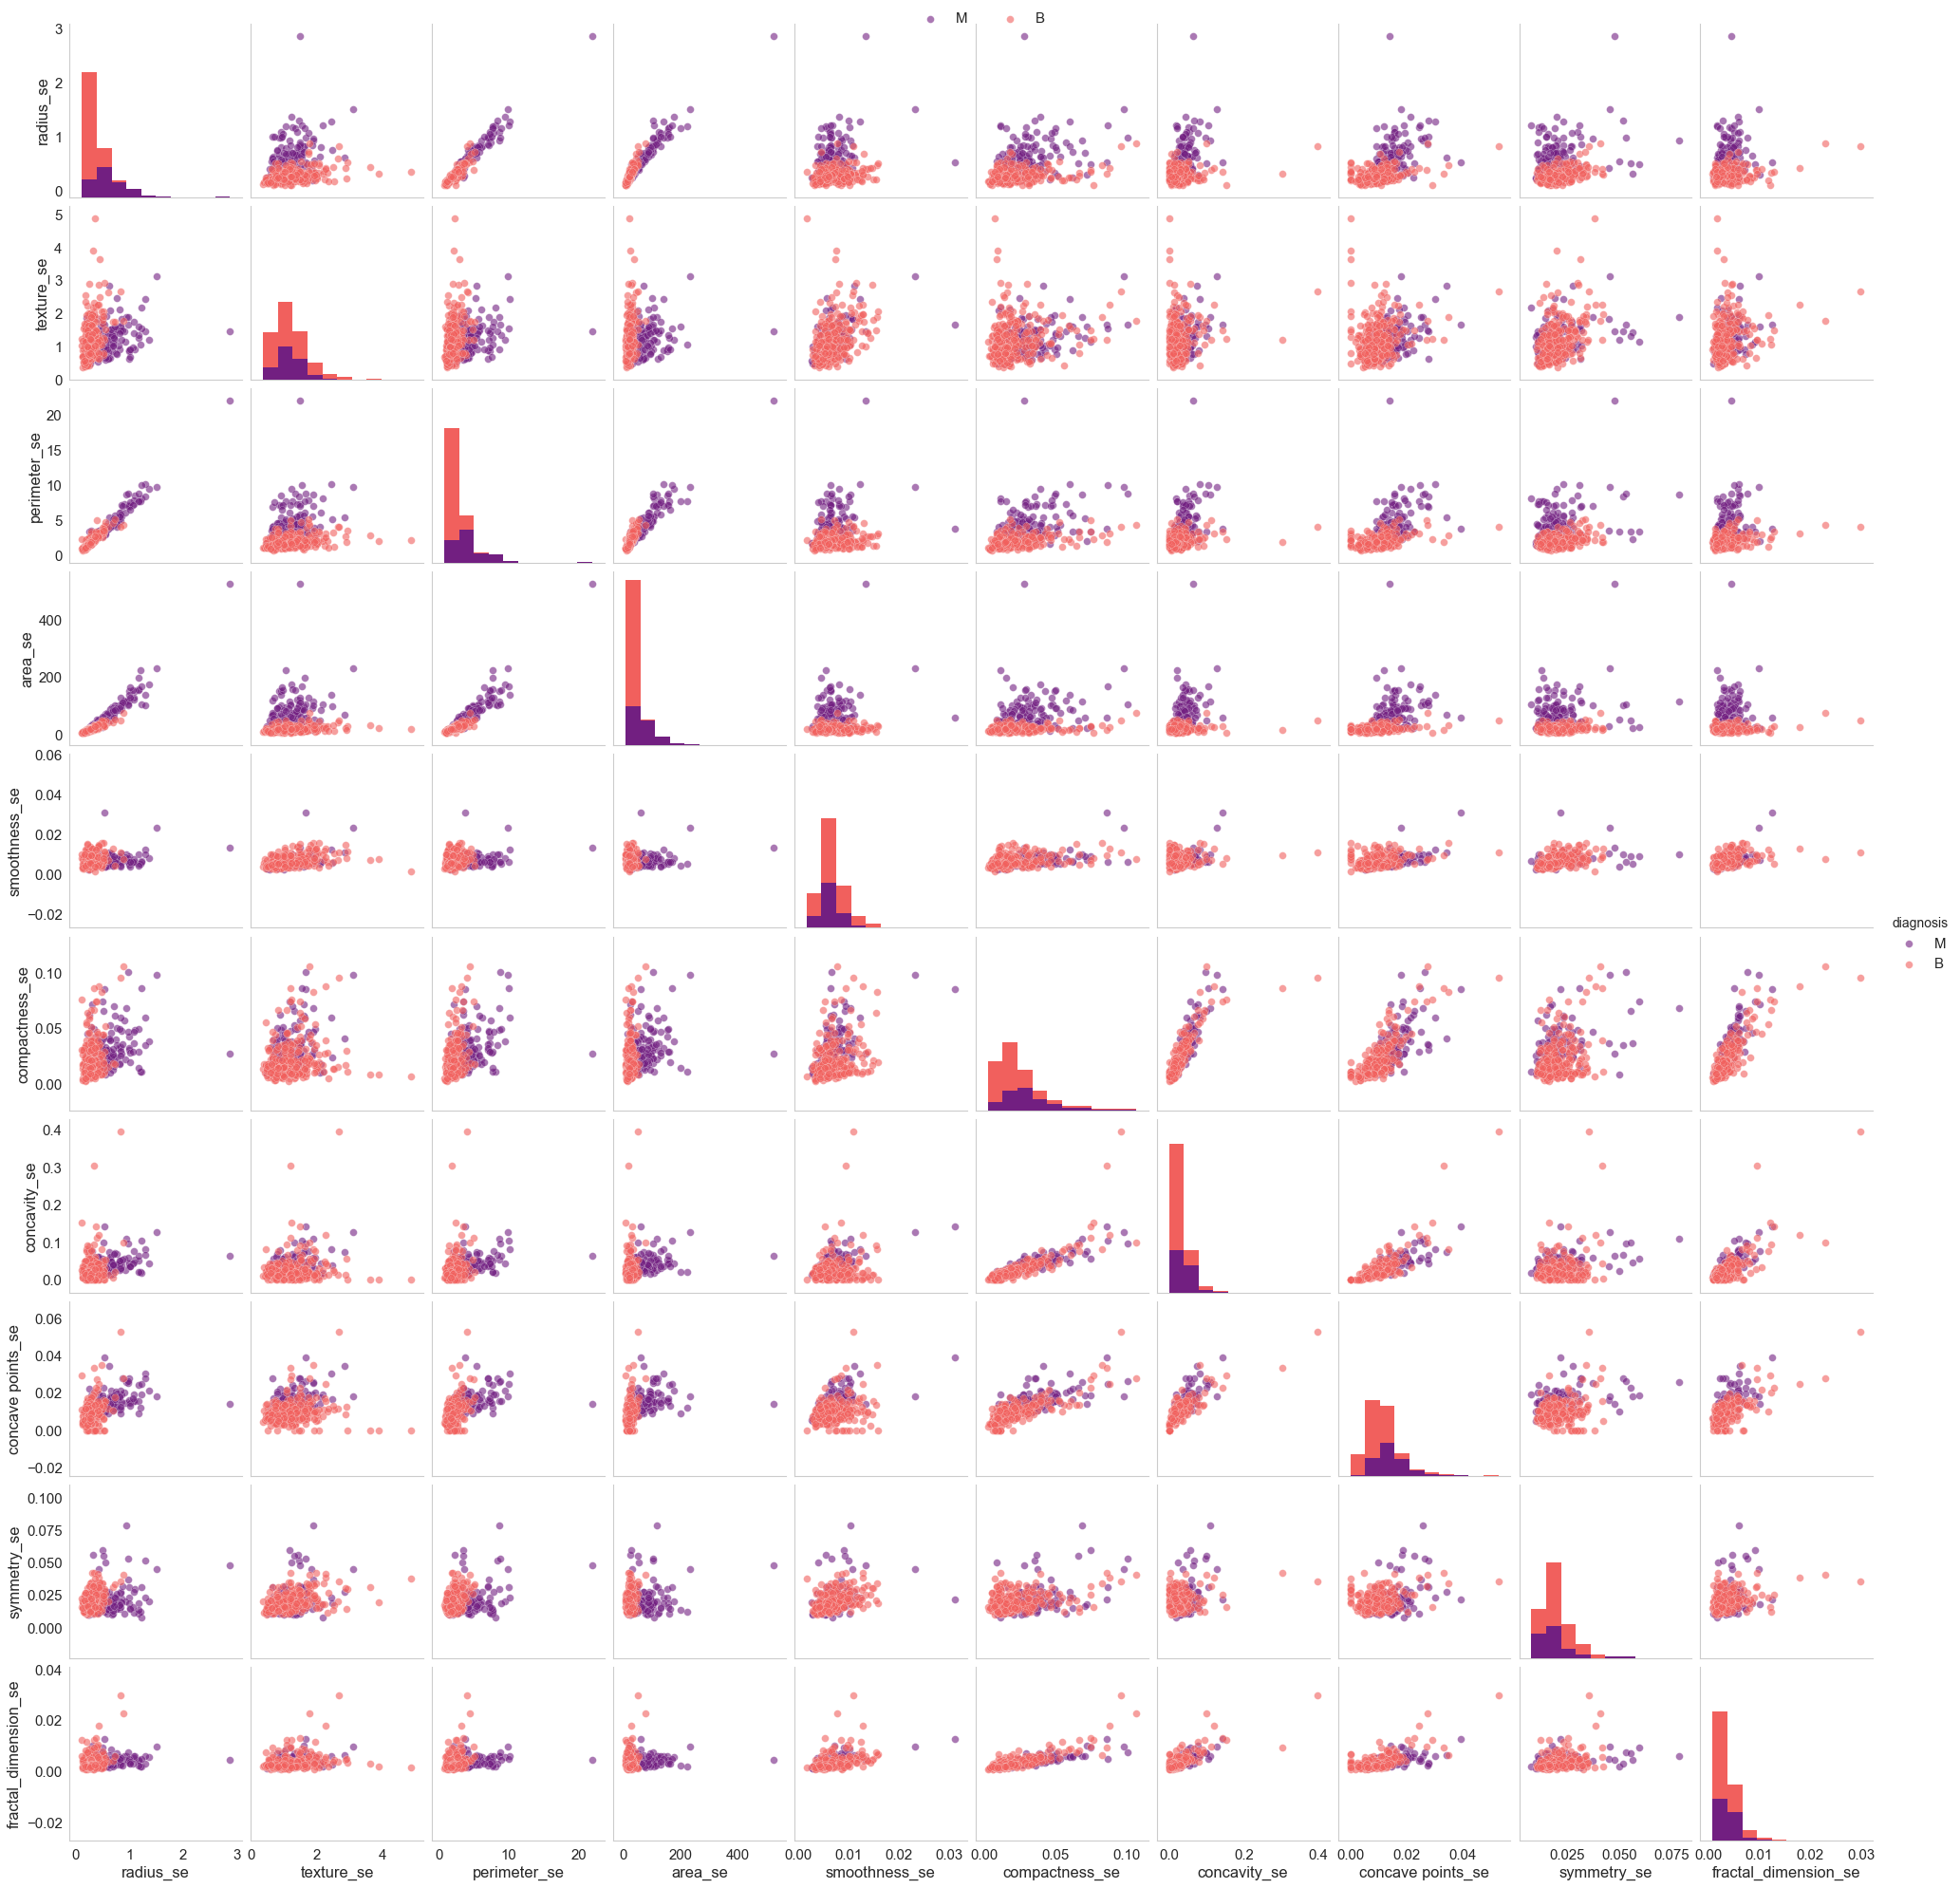

In [11]:
p = sns.pairplot(train[error_feats], hue='diagnosis',
             plot_kws={'alpha':0.6, }, palette='magma')

plt.subplots_adjust(hspace=0.05, wspace=0.05)
handles = p._legend_data.values()
labels = p._legend_data.keys()
p.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=2)
p.fig.set_dpi(80);

### Worst Features Plot


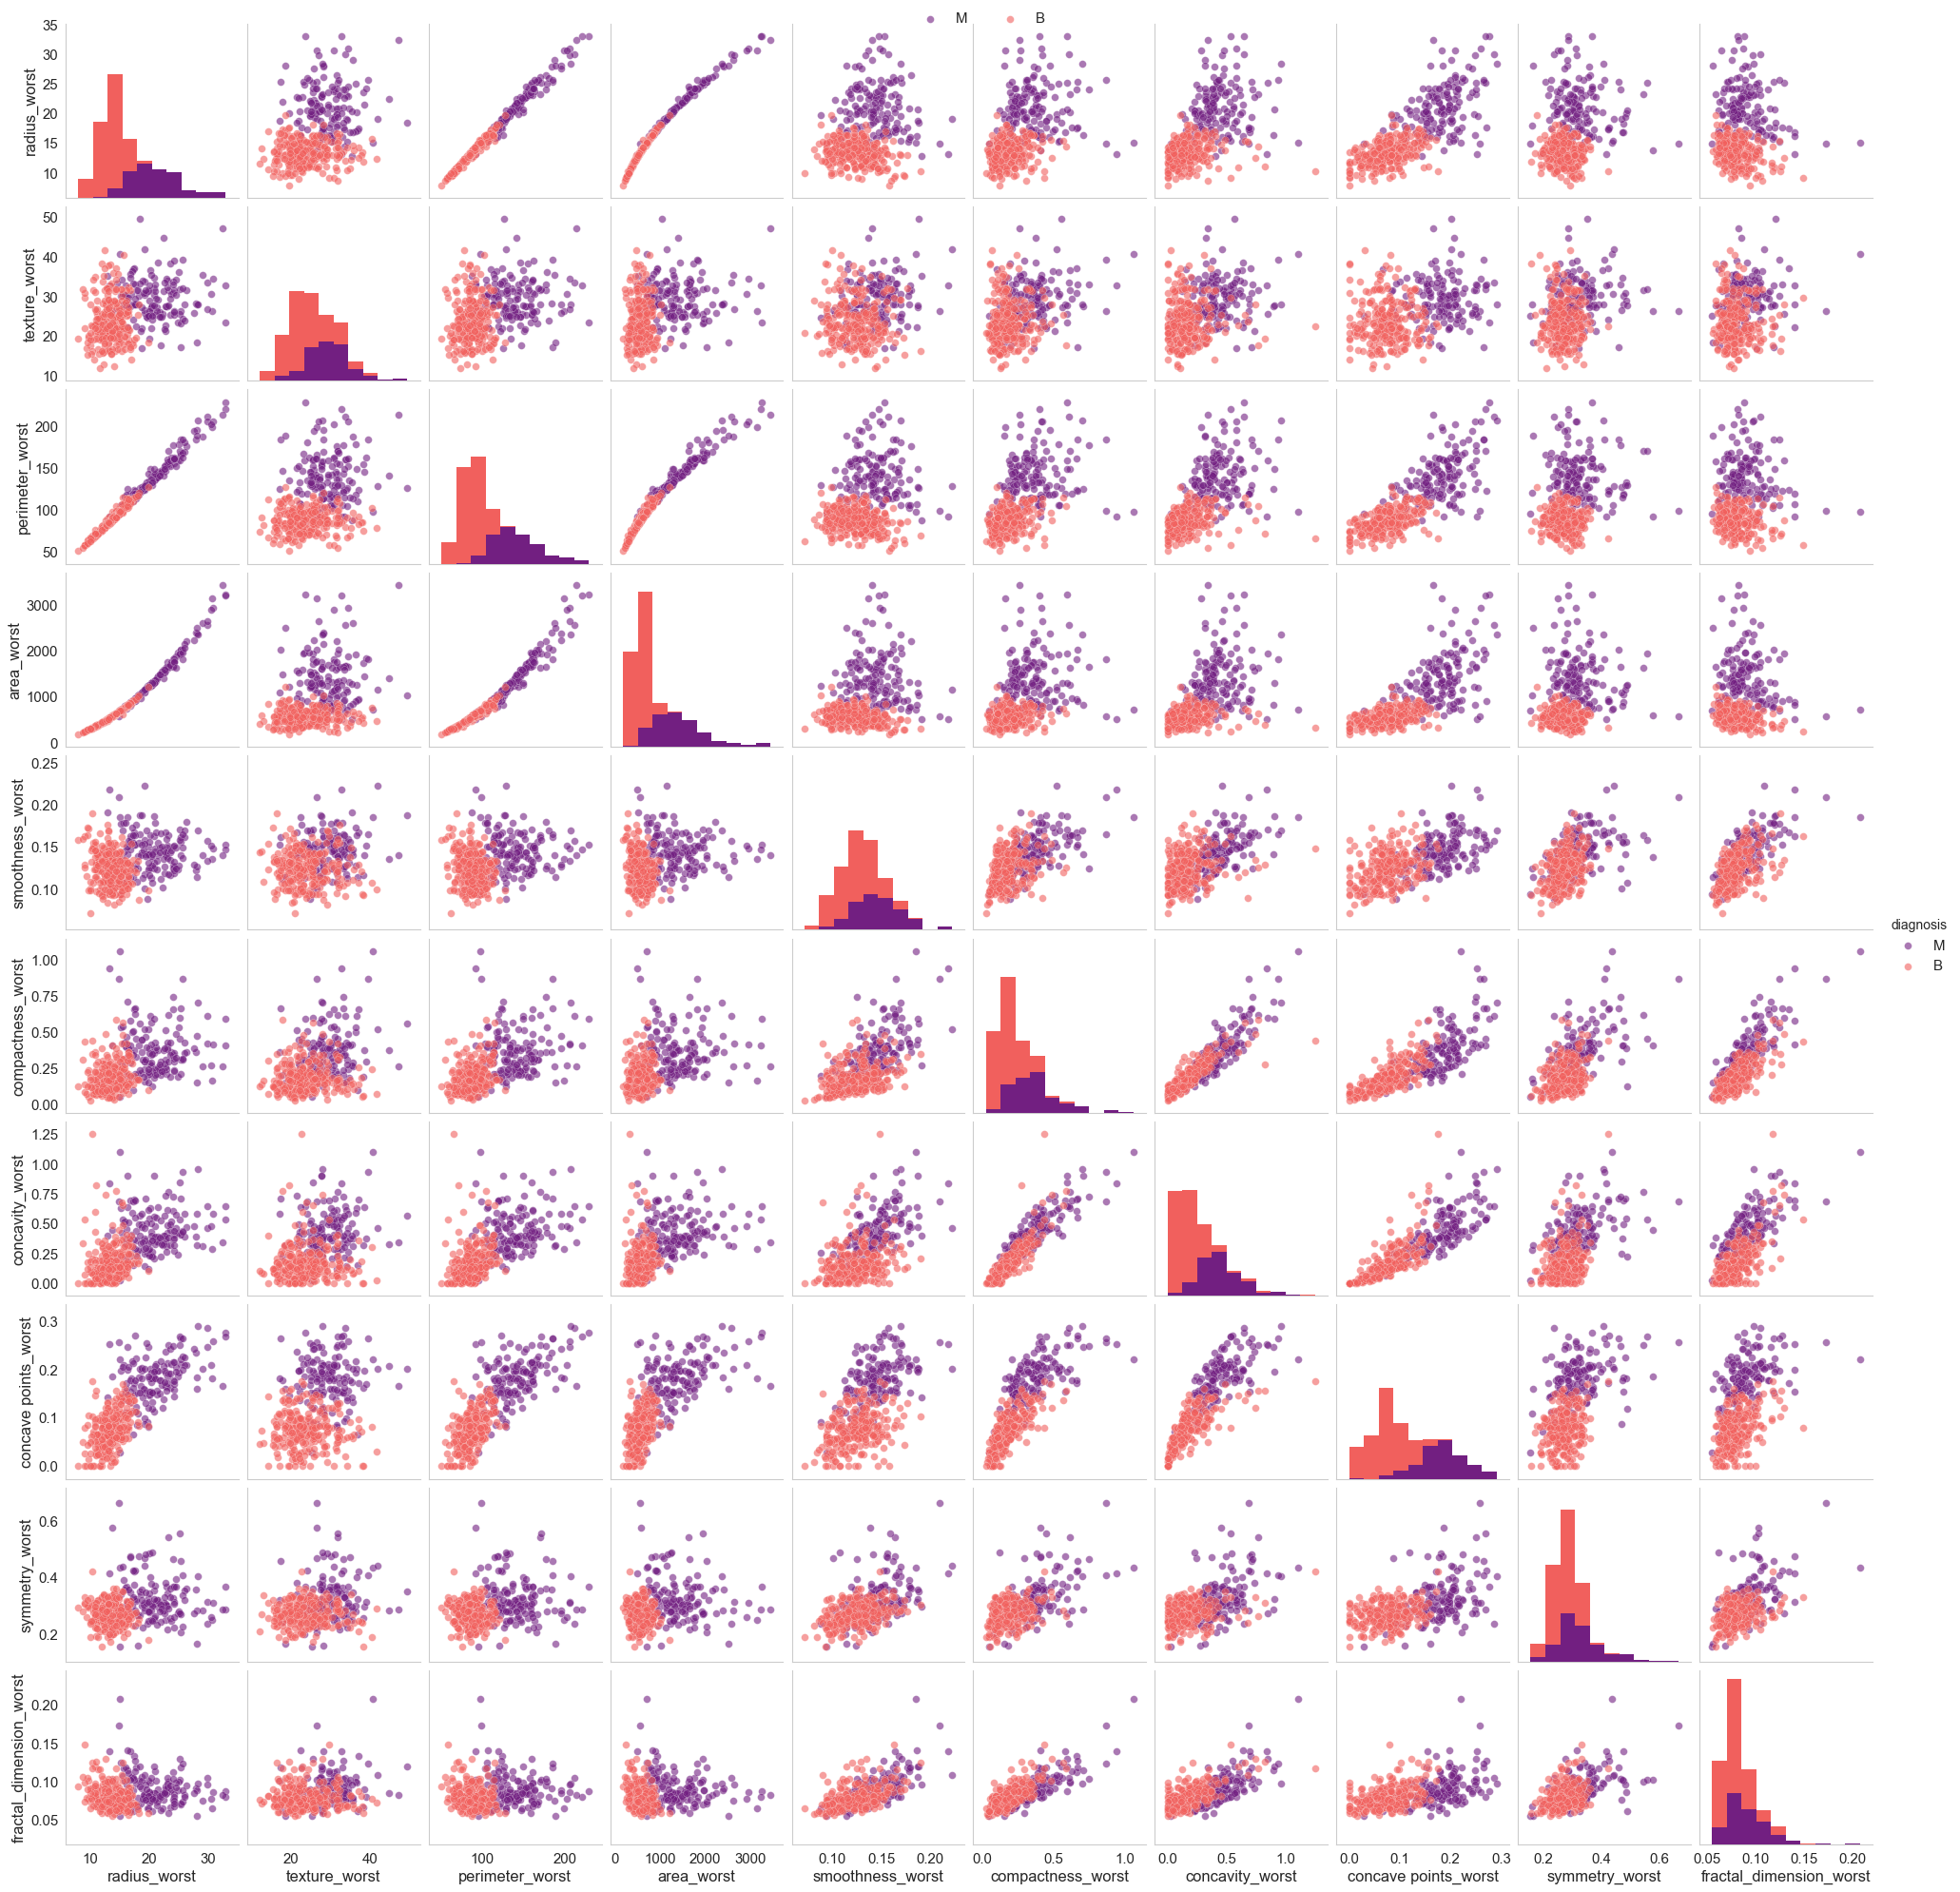

In [12]:
p = sns.pairplot(train[worst_feats], hue='diagnosis',
                 plot_kws={'alpha':0.6}, palette='magma')

plt.subplots_adjust(hspace=0.05, wspace=0.05)
handles = p._legend_data.values()
labels = p._legend_data.keys()
p.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=2)
p.fig.set_dpi(80);

---

## 2.3 - Correlations
To calculate the correlations we can use the pandas *corr* method. 

To visualize it better we can use the classic seaborn's heatmap - which is perfectly fine - but I will plot it using horizontal bar charts. 
<blockquote>
    <font color='darkblue'>
            <b>The downside of not plotting a heatmap</b> is that we do not see how features are correlated to each other: there might be redundant features we don't need to feed a machine learning model. We can already see highly correlated features from our previous plots (e.g. Perimeter and Area), but I've chosen to keep them all and let the algorithms decide for them selves which ones are important and which ones aren't (feature selection and regularization).
    </font>
    </blockquote>

In [13]:
sns.set(style='whitegrid')

In [14]:
def feat_class(feat):
    if 'worst' in feat:
        return 'Worst'
    elif 'mean' in feat:
        return 'Mean'
    elif 'se' in feat:
        return 'Standard Error'

In [15]:
corrs = train.corr()[['Target']].sort_values('Target',
                                             ascending=False)[1:].reset_index()
corrs.rename(columns={'index':'Features'}, inplace=True)
corrs['Class'] = corrs['Features'].apply(feat_class)
corrs['Main'] = corrs['Features'].apply(lambda x: x.split('_')[0])

### Correlation by Feature Type
First, lets see if we can find a predominant type of feature (*worst, mean or se*). Did we visualize it correctly in the previous plots?

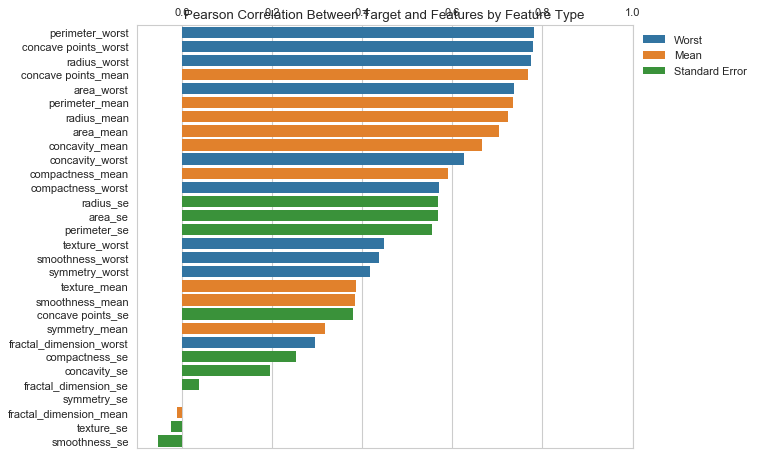

In [16]:
fig, ax = plt.subplots(figsize=(8,7), dpi=80)
sns.barplot(data=corrs, x='Target', y='Features', ax=ax,
            hue='Class', dodge=False, palette='tab10')
ax.legend(bbox_to_anchor=(1.0, 1.0), loc=2)
ax.xaxis.tick_top()
ax.xaxis.label.set_visible(False)
ax.set_xlim(-0.1, 1.0)
ax.yaxis.label.set_visible(False)
ax.set_title('Pearson Correlation Between Target and Features by Feature Type');

**Insights from the plot:**
- At a first look, Standard Error seems to be the least important kind of measure we are dealing with (of the 6 lowest, 5 are standard error). We correctly pointed out that it did have an impact but only on a few features (radius, area and perimeter).
- Aside from that, Worst has the top 3, follower by Mean;

### Correlation by Main Features
Next we will plot the same graph but grouping the correlations by their main features (area, radius, etc... ).

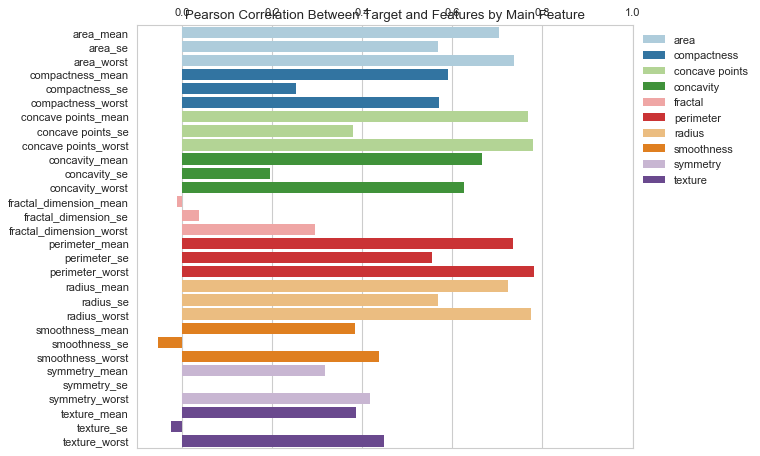

In [17]:
plot_ord = corrs.sort_values('Features')['Features']
hue_ord = corrs.sort_values('Main')['Main'].unique()

fig, ax = plt.subplots(figsize=(8,7), dpi=80)
sns.barplot(data=corrs, x='Target', y='Features', ax=ax, order=plot_ord,
            hue='Main', hue_order=hue_ord, dodge=False, palette='Paired')
ax.legend(bbox_to_anchor=(1.0, 1.0), loc=2)
ax.xaxis.tick_top()
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.set_xlim(-0.1, 1.0)
ax.set_title('Pearson Correlation Between Target and Features by Main Feature');

<b>Insights from the plot</b>:
<ul>
<li>We can observe that <u>for all features except for Fractal Dimension have a similar pattern</u>: The two highest correlated feature types are WORST and MEAN and the lowest is the STANDARD ERROR.</li>
<li>Fractal dimension has been the exception since 3.1. Apparently all that matters in terms of this feature are the worst measures.</li>
</ul>

That said, we must remember that Pearson's correlation can only measure two individual features and we can't see how the combination of features influence in our target. As I've mentioned: I will keep them and let my model decide.

# 3 - First Models

On this section we will:
- Pick different out-of-the-box models and evaluate them in our training data;
- See if the first results give us any tips on how to improve our data somehow and test some ideas (feature engineering);
- Choose the top five most promising and distinct models

The models we will be using are:
- Logistic Regression
- LDA
- Support Vector Classifier (SVC)
- Linear SVC
- Decision Tree
- Random Forests
- Gradient Boos Classifier
- AdaBoost Classifier
- XGB
- K-Nearest Neighbors

In [18]:
# Importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

# Importing other tools
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

<hr>

## 3.1 - Setting Up the Training

We have a small dataset. In order to make the most out of it we will be using cross-validation to evaluate our models . 

First lets create the models with standard parameters.

In [19]:
# Defining random seed
seed=42

# Creating Models
logreg = LogisticRegression(solver='lbfgs', random_state=seed)
lda = LinearDiscriminantAnalysis()
svc = SVC(random_state=seed, probability=True)
lin_svc = LinearSVC(random_state=seed)
l_svc = CalibratedClassifierCV(lin_svc, cv=5)
dtree = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(10, random_state=seed)
gdb = GradientBoostingClassifier(random_state=seed)
adb = AdaBoostClassifier(random_state=seed)
xgb = XGBClassifier(random_state=seed)
knn = KNeighborsClassifier()

first_models = [logreg, lda, svc, l_svc,
                dtree, rf, gdb, adb, xgb, knn]
first_model_names = ['Logistic Regression', 'LDA', 'SVC', 'Linear SVC',
                    'Decision Tree', 'Random Forest', 'GradientBoosting',
                    'AdaBoost', 'XGB', 'K-Neighbors'] 

# Defining other steps
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=seed)
std_sca = StandardScaler()

Splitting X and Y for our training and test sets

In [20]:
X_train = train.drop(['diagnosis', 'Target'] ,axis=1)
y_train = train['Target']

---

## 3.2 - Evaluating the first models

### Choosing the Proper Measure to Evaluate the Model Performance
There are **a lot** of ways to measure the quality of your model and we must choose it carefully. This is one of the most important parts of a Machine Learning Project.

Our objective isn't classifying correctly the tumors. If that was the case simply using Accuracy - which is the ratio of correctly predicted classes - would do the job.

However, the objective of this analysis is **detecting malignant tumors**. And how do we measure that? Not with Accuracy, but with **RECALL**. 

Recall answers the following question: *from all the malignant tumors in our data, how many did we catch?*. Recall is calculated by dividing the True positives by the total number of positives (positive = malignant). It is important to realize that a high Recall doesn't mean a high Accuracy and there is often a trade-off between different performance measures. 

That said, we will be making our decisions based on Recall but we will also measure Accuracy to see the difference between them. Moving on!

<blockquote>
    <font color='darkblue'>
        <b>Coding Explanation:</b><br>
        The code on the cell below does the following steps:
        <ol>
            <li><b>Setting up:</b></li>
            <ol>
                <li>Creates an array to store the out-of-fold predictions that we will use later on. Its shape is the training size by the number of models we have;</li>
                <li>Creates a list to store the Accuracy and Recall scores</li>
            </ol>
            <li><b>Outer Loop</b>: Iterating through Models</li>
            <ol>
                <li>Creates a data pipeline with the scaler and the model</li>
                <li>Creates two arrays to store each fold's accuracy and recall</li>
                <li>Executes the inner loop</li>
                <li>By the end of the cross-validation, stores the mean and the standard deviation for those two measures in the scores list</li>
            </ol>
            <li><b>Inner Loop</b>: Cross-Validation</li>
            <ol>
                <li>Splits the training data into train/validation data</li>
                <li>Fits the model with the CV training data and predicts the validation data</li>
                <li>Stores the out-of-fold predictions (which is the validation predictions) in oof_preds</li>
                <li>Measures the Accuracy and Recall for the fold and stores in an array</li>
            </ol>
        </ol>
    </font>
    </blockquote>

In [21]:
train_size = X_train.shape[0]
n_models = len(first_models)
oof_pred = np.zeros((train_size, n_models))
scores = []

for n, model in enumerate(first_models):
    model_pipeline = Pipeline(steps=[('Scaler', std_sca),
                                     ('Estimator', model)])
    accuracy = np.zeros(n_folds)
    recall = np.zeros(n_folds)
    
    for i, (train_ix, val_ix) in enumerate(skf.split(X_train, y_train)):
        x_tr,  y_tr  = X_train.iloc[train_ix], y_train.iloc[train_ix]
        x_val, y_val = X_train.iloc[val_ix],   y_train.iloc[val_ix]
        
        model_pipeline.fit(x_tr, y_tr)
        val_pred = model_pipeline.predict(x_val)
        
        oof_pred[val_ix, n] = model_pipeline.predict_proba(x_val)[:,1]
        
        fold_acc = accuracy_score(y_val, val_pred)
        fold_rec = recall_score(y_val, val_pred)
        
        accuracy[i] = fold_acc
        recall[i] = fold_rec
    
    scores.append({'Accuracy'          : accuracy.mean(),
                   'Recall'            : recall.mean()})

<blockquote>
    <font color='darkblue'>
        <b>Why not scale the data before? Why the pipeline?</b><br>
        This is a common and easy to avoid data-leakage mistake when using Scalers or other feature processing algorithms. In the case of standard scaling, it follows a simple process: it reads the data and calculates its mean and standard deviation then it centers the dataset mean to 0 and scales its standard deviation to 1<br>
        <br>Let's say we weren't using cross-validation and instead we just had a train and a validation set. If we were to fit our StandardScaler with all the data, our scaled dataset would have information on the test set distribution - aka data leakage. We don't want our model to 'see' any data other than the training set so this is to be avoided.<br>
        <br>This applies to cross-validation as well. When cross-validating, we create N train-validation splits and for every fold we must scale our data based on the training data only. So, how do we do that?<br>
        <br>We use a <b>Pipeline</b> which <i>glues</i> our Model to other data preprocessing APIs. In our case, when er fit our pipeline we are fitting and transforming the data with StandardScaler and then fitting the ML Model. This could also be done separatedly, by having more code explicitly fitting and transforming the data for each fold. However, using Pipelines (especially when there are more processing steps) makes it cleaner and more reusable/scalable.<br>
    </font>
    </blockquote>


### First Models' Results

In [22]:
measure_cols = ['Accuracy', 'Recall']#, 'Accuracy Std.Dev.', 'Recall Std.Dev.']

first_scores = pd.DataFrame(columns=measure_cols)

for name, score in zip(first_model_names, scores):
    
    new_row = pd.Series(data=score, name=name)
    first_scores = first_scores.append(new_row)
    
first_scores = first_scores.sort_values('Recall', ascending=False)
first_scores

Accuracy    Recall
SVC                  0.972215  0.945057
Logistic Regression  0.972278  0.931724
GradientBoosting     0.954589  0.931494
K-Neighbors          0.969747  0.925057
XGB                  0.952089  0.924828
AdaBoost             0.952215  0.918621
Random Forest        0.949715  0.905287
Linear SVC           0.959684  0.904828
Decision Tree        0.916835  0.904828
LDA                  0.949684  0.871264

This table shows us each model ordered by its Recall, descending.

**Insights**:
- SVC and Logistic Regression got the highest scores, while Decision Tree and LDA got the lowest.
- LDA does not provide optimal results if the features are highly correlated - which some are. This poor result isn't a big surprise. 
- All the other models got above 95% accuracy and 90% recall on a first try.

<hr>

## 3.3 - Feature Selection

Most models provide a method that returns feature importances or coefficients so we can have an idea of what is being considered the most important features of our dataset. SVC, Linear SVC and KNN are the ones that don't have it.

Let's see if we can find anything from the other models preferences. 

In [23]:
feature_names = X_train.columns
feat_imp_df = pd.DataFrame(columns=first_model_names, index=feature_names)

# Dropping the Models that don't have feature importances for this analysis
feat_imp_df.drop(['SVC', 'Linear SVC', 'K-Neighbors'], axis=1, inplace=True)

# I'm using absolute values for logistic Regression and LDA because we only care about the magnitude of the coefficient, not its direction 
feat_imp_df['Logistic Regression'] = np.abs(logreg.coef_.ravel())
feat_imp_df['LDA'] = np.abs(lda.coef_.ravel())
feat_imp_df['Decision Tree'] = dtree.feature_importances_
feat_imp_df['Random Forest'] = rf.feature_importances_
feat_imp_df['GradientBoosting'] = gdb.feature_importances_
feat_imp_df['AdaBoost'] = adb.feature_importances_
feat_imp_df['XGB'] = xgb.feature_importances_

So this is how our table looks like right now. Each model has its own measure for each feature's importances. You will notice that some measures are in different scales. 

In order to compare the importances between the models we need to scale them. I will use sklearn MinMaxScaler to shrink them to a [0, 1] interval and then sum the features importances for each model.

In [24]:
feat_imp_df.head(3)

Logistic Regression       LDA  Decision Tree  Random Forest  \
radius_mean                0.530458  0.047037            0.0       0.085438   
texture_mean               0.688028  0.267523            0.0       0.002602   
perimeter_mean             0.492612  5.692956            0.0       0.100797   

                GradientBoosting  AdaBoost       XGB  
radius_mean             0.001444       0.0  0.009079  
texture_mean            0.000313       0.1  0.016920  
perimeter_mean          0.000010       0.0  0.016536

In [25]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

scaled_fi = pd.DataFrame(data=mms.fit_transform(feat_imp_df),
                         columns=feat_imp_df.columns,
                         index=feat_imp_df.index)
scaled_fi['Overall'] = scaled_fi.sum(axis=1)

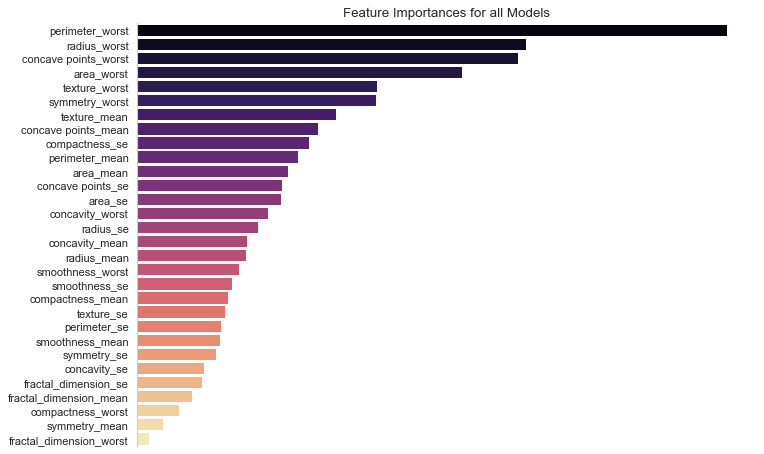

In [26]:
ordered_ranking = scaled_fi.sort_values('Overall', ascending=False)
fig, ax = plt.subplots(figsize=(10,7), dpi=80)
sns.barplot(data=ordered_ranking, y=ordered_ranking.index, x='Overall', palette='magma')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)
ax.grid(False)
ax.set_title('Feature Importances for all Models');

**Insights**:
- Worst Perimeter is the most important features between models;
- There is a clear preference for Worst features on models. The top 6 features are 'Worst';
- All Fractal Dimension features are in the bottom 5. Symmetry's Mean and S.Error is pretty low as well, but Symmetry Worst, curiously, is pretty high. 

This is what our models have to tell us. If we decided on dropping features based on the correlations plotted in Chapter Three we would've gotten some of them wrong. 

Let's try now removing the Bottom 5 and repeat the training to see if we get any better results. Just copying the code already used before.

In [27]:
train_v2 = train.drop(ordered_ranking.index[:-6:-1], axis=1)
test_v2 = test.drop(ordered_ranking.index[:-6:-1], axis=1)

X_train_v2 = train_v2.drop(['diagnosis', 'Target'] ,axis=1)
X_test_v2 = test_v2.drop(['diagnosis', 'Target'] ,axis=1)

In [28]:
train_size = X_train_v2.shape[0]
test_size = test.shape[0]
n_models = len(first_models)
oof_pred = np.zeros((train_size, n_models))
scores = []

for n, model in enumerate(first_models):
    model_pipeline = Pipeline(steps=[('Scaler', std_sca),
                                     ('Estimator', model)])
    accuracy = np.zeros(n_folds)
    recall = np.zeros(n_folds)
    
    for i, (train_ix, val_ix) in enumerate(skf.split(X_train_v2, y_train)):
        x_tr,  y_tr  = X_train_v2.iloc[train_ix], y_train.iloc[train_ix]
        x_val, y_val = X_train_v2.iloc[val_ix],   y_train.iloc[val_ix]
        
        model_pipeline.fit(x_tr, y_tr)
        val_pred = model_pipeline.predict(x_val)
        
        oof_pred[val_ix, n] = model_pipeline.predict_proba(x_val)[:,1]
        
        fold_acc = accuracy_score(y_val, val_pred)
        fold_rec = recall_score(y_val, val_pred)
        
        accuracy[i] = fold_acc
        recall[i] = fold_rec
    
    scores.append({'Accuracy'          : accuracy.mean(),
                   'Recall'            : recall.mean()})

In [29]:
measure_cols = ['Accuracy', 'Recall']

fs_scores = pd.DataFrame(columns=measure_cols)

for name, score in zip(first_model_names, scores):
    
    new_row = pd.Series(data=score, name=name)
    fs_scores = fs_scores.append(new_row)
    
fs_scores = fs_scores.sort_values('Recall', ascending=False)

In [30]:
d={'First Scores':first_scores, 'Less Features':fs_scores}
pd.concat(d, axis=1, sort=False)

First Scores           Less Features          
                        Accuracy    Recall      Accuracy    Recall
SVC                     0.972215  0.945057      0.974747  0.945287
Logistic Regression     0.972278  0.931724      0.972278  0.931724
GradientBoosting        0.954589  0.931494      0.954620  0.931724
K-Neighbors             0.969747  0.925057      0.959747  0.911724
XGB                     0.952089  0.924828      0.949557  0.917931
AdaBoost                0.952215  0.918621      0.957247  0.932184
Random Forest           0.949715  0.905287      0.957184  0.925057
Linear SVC              0.959684  0.904828      0.954620  0.891034
Decision Tree           0.916835  0.904828      0.916835  0.877241
LDA                     0.949684  0.871264      0.949684  0.871264

**Insights from Feature Selection**:
- What changed?
    - Logistic Regression and LDA didn't change at all;
    - SVC and Gradient Boosting slightly improved (probably just one extra sample);
    - KNN, Decision Tree, Linear SVC and XGB got worst;
    - AdaBoost and Random Forest greatly improved
- Our bottom models are the same as before (LDA, Decision Tree and Linear SVC). 


<b>It is not clear if removing the features was a good decision or not. When in doubt, opt for the simpler choice: We are removing them.</b>

We will start our model selection by dropping Decision Tree and LDA. We will also drop Linear SVC because we can tweak the regular SVC parameters to obtain a Linear SVC.

<blockquote>
    <font color='darkblue'>
        <b>Linear SVCs</b> train and predict really faster than a SVC with linear parameters, but once more, our dataset is small so it's not a problem
    </font>
</blockquote>

## 3.4 - Analysing Model Errors

We will start selecting the next models by creating a dataframe with all the models' out-of-fold predictions to compare their results.

In [31]:
oof_dataframe = pd.DataFrame(data=oof_pred, columns=first_model_names, index=train.index)
oof_dataframe['Target'] = train['Target']
oof_dataframe = oof_dataframe.drop(['LDA', 'Decision Tree', 'Linear SVC'], axis=1)

### Can't get them right
Lets see if we can find examples that all models got the classification wrong. The function defined below does just that.

In [32]:
def all_wrong(x):
    predictions = sum(x[:7])
    target = x[7]
    if (target == 1 and predictions == 0) or \
       (target == 0 and predictions == 7):
        return True
    
    else: return False

In [33]:
oof_dataframe['All_wrong'] = round(oof_dataframe).apply(all_wrong, axis=1)
oof_dataframe.query("All_wrong == True")

Logistic Regression       SVC  Random Forest  GradientBoosting  AdaBoost  \
40              0.080131  0.079808            0.1          0.003485  0.274783   
255             0.336703  0.131371            0.2          0.006773  0.396876   
135             0.094297  0.027254            0.0          0.000876  0.434823   
41              0.383448  0.414611            0.3          0.000729  0.441669   
297             0.001982  0.003970            0.0          0.000139  0.292358   

          XGB  K-Neighbors  Target  All_wrong  
40   0.011536          0.2       1       True  
255  0.064933          0.2       1       True  
135  0.013378          0.0       1       True  
41   0.024159          0.4       1       True  
297  0.002549          0.0       1       True

We have those five tumors that no model got right. By the looks of it, AdaBoost was the one that was closest to classifying it right. (The standard threshold is 0.5 probability). I'm out of ideas to further explore these for now.

### Getting Different Opinions
Simply plotting correlations will be hard to distinguish which models are least correlated with the rest. This is due to the fact that all remaining models have over 95% accuracy so their overall correlation will be high.

A better way to approach this is by looking at the tumors that our models classified wrong and/or that they didn't agree on the classification. We can map the models' predictions for 'Easy' ones (that most of them got right) and filter them out. This way we can focus only on how different their 'opinions' are.

<blockquote>
    <h3><font color='darkblue'>On Model Stacking</font></h3>
        <p><font color='darkblue'>
            <b>'Why pick models that don't agree with each other?'</b><br>
                We are looking for uncorrelated models for model stacking and this question is a really common one. Why is it better?<br>
                <a href='http://blog.kaggle.com/author/bengorman/'>Ben Gorman</a> has a nice post on this topic explaining it and I suggest you read it if you want to get the intuition on stacking. (<a href='http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/'>blog post</a>)
        </font></p>
        <p><font color='darkblue'>
            Nonetheless I will try to put it <u>in simple words</u> here:<br>
            Model Stacking is just like building any kind of team. You don't want everyone in your team good in the same things, you want diversity so you can perform well on different cases/scenarios. If you want to build a diagnosis medical team for all kinds of scenarios you probably don't want only infectologists. Putting it this way, it is intuitively wiser to get different kinds of specializations on your team. 
        </font></p>
        <p><font color='darkblue'>
            <u>It works exactly the same in Machine Learning.</u>
        </font></p>
        <p><font color='darkblue'>
            <b>Imagine we only had three models and had to choose two: A Linear SVC, a Logistic Regression and a KNN</b>. Both Linear SVC and Logistic Regression are linear models so they have similar results. Let's also say that:
        </font></p>
            <ul><font color='darkblue'>
                <li>We only have two features: Radius and Perimeter</li>
                <li><b>Linear SVC and Logistic Regression</b> perform best on cases where all features are high (high radius and perimeter)</li>
                <li><b>KNN</b> performs best on the opposite scenario - low radius and perimeter</li>
            </font></ul>
        <p><font color='darkblue'>
            In other words, LinearSVC and LogReg are highly correlated with eachother but not with KNN. The obvious choice is to pick KNN and one of the other ones, otherwise we will never get all cases right. Let's pick LSVC for this example.
        </font></p>
        <p><font color='darkblue'>
            The fantastic thing about Model Stacking is that our second level model is able to learn when to use each models' opinion for every data point. If we - ontop of Radius and Perimeter features - added the predictions from KNN and and LSVC as features, our second-level model is able to, for instance, associate high radius and perimeter cases with LSVC predictions and don't listen to KNN on such cases.
        </font></p>

In [34]:
# We have 7 models + our target so the perfect scores would be 0 and 1
# I am also adding to the Easy Ones group cases that only one model disagrees with the rest
oof_dataframe['Easy_one'] = round(oof_dataframe).sum(axis=1).isin([0, 1, 7, 8])

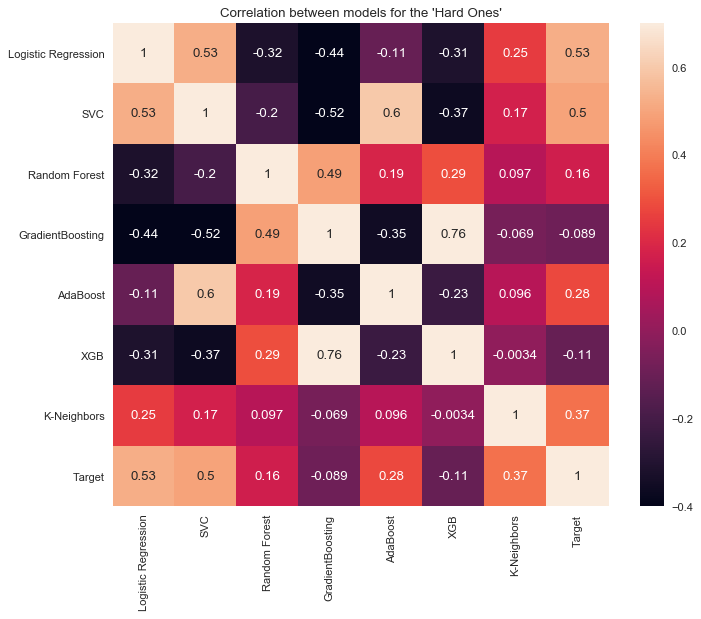

In [35]:
# We define our Hard_ones dataset by filtering easy_ones out
hard_ones = oof_dataframe.query("Easy_one == False and \
    All_wrong == False").drop(['Easy_one', 'All_wrong'], axis=1)

plt.figure(figsize=(10,8), dpi=80)
sns.heatmap(hard_ones.corr(),
            vmin=-0.4, vmax=0.7, annot=True)
plt.title("Correlation between models for the 'Hard Ones'");

This heatmap shows correlation between prediction probabilities for all models on the hard tumor samples defined above. We are looking at the 5% our models can't get right.

**Insights:**
- The most correlated models are XGB and GradientBoosting, which is to be expected. Between those two, however, GradientBoosting is less correlated with the other models (-0,44 with Logistic Regression and -0,52 with SVC). **We should keep GradientBoostin and drop XGB**;
- **SVC and Logistic Regression** are the ones with the highest correlation with the Target on these hard data points and they are fundamentally different. **Keeping them**.
- **KNN** also has a high correlation with the target and an overall low correlation with the other models - **stays**.
- Finally we will also **keep Random Forest** to have another one besides Gradient Boosting to disagree with Logistic Regression and SVC.

This leaves us with five models out of our ten initial ones:
- Logistic Regression
- SVC
- GradientBoosting
- Random Forest
- KNN

# 4 - Fine Tuning the System

## 4.1 - Hyperparameters
Listed below are the five models and the parameters we are going to tune (not all will be listed).

![](https://i.imgur.com/PMfff5N.png)

## 4.2 - Tuning Tools

Sklearn's GridSearchCV is our best friend for parameter tuning. We will optimize our models for Recall. Lets start importing it. 

In [36]:
from sklearn.model_selection import GridSearchCV

# Defining this function to make our lives easier on tuning
def train_gridsearch(model, x=X_train_v2, y=y_train, name=None):
    t_model = model
    t_model.fit(x, y)
    print(30*'-')
    if name != None: print(name)
    print('\nBest Parameters:')
    for item in t_model.best_params_.items():
        print(item[0], ': ', item[1])
    print('\nScore: ', t_model.best_score_, '\n')
    print(30*'-')

<blockquote>
    <font color='darkblue'>
        A common way to start searching for parameters is to pick multiples of 10 and then refine it as you go. <br>
        Another way to do this is to use <b>RandomizedSearchCV</b> and create a large parameter space. This API will randomly pick parameters to test (this technique is more recommended if you have too many parameters to try and don't have the time)
    </font>
    </blockquote>

One last thing before starting our tuning is to create another Pipeline step for the log transformation we applied in Chapter 3.1. This transformation might be helpful and we want to try it with GridSearchCV

We can create a Logger class using *BaseEstimator* and *TransformerMixin* so we can put it inside a pipeline. Inside this Logger class we can define our log transformation function and set a parameter to trigger it.

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

class Logger(BaseEstimator, TransformerMixin):
    def __init__(self, apply_log = True):
        self.apply_log = apply_log
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        logX = X.copy()
        
        if self.apply_log:
            logX = np.log1p(X)
            return logX
    
        else: return X

logger = Logger()

## 4.3 - Logistic Regression

The first model we are tuning is Logistic Regression. Let's start listing the parameters in a dictionary so we can feed our GridSearchCV      

In [38]:
# Logistic Regression Initial Parameters
log_pams = [{'M__solver':['liblinear'],
             'M__class_weight':[None, 'balanced'],
             'M__C': [0.001, 0.01, 0.1, 1, 10, ],
             'M__penalty':['l1'], 
             'L__apply_log':[True, False]},
            {'M__solver':['lbfgs'],
             'M__class_weight':[None, 'balanced'],
             'M__C': [0.001, 0.01, 0.1, 1, 10, ],
             'M__penalty':['l2'], 
             'L__apply_log':[True, False]}]

# It is important to apply the log transformer before the scaling otherwise we will always get 'number near 0' error.
log_pipe = Pipeline(steps=[('L', logger),
                           ('S', std_sca),
                           ('M', logreg)])

log_gs = GridSearchCV(log_pipe, log_pams, scoring='recall',
                      cv=skf, n_jobs=-1, iid=False)

train_gridsearch(log_gs)

------------------------------

Best Parameters:
L__apply_log :  True
M__C :  1
M__class_weight :  balanced
M__penalty :  l1
M__solver :  liblinear

Score:  0.9662068965517243 

------------------------------


Our best C is at 1 so we might refine our parameters near that value. A second run on parameter tuning could look like:

In [39]:
# Logistic Regression Initial Parameters
log_pams = [{'M__solver':['liblinear'],
             'M__class_weight':['balanced'],
             'M__C': [0.5, 0.75, 1, 1.25, 1.5],
             'M__penalty':['l1'], 
             'L__apply_log':[True]}]

# It is important to apply the log transformer before the scaling otherwise we will always get 'number near 0' error.
log_pipe = Pipeline(steps=[('L', logger),
                           ('S', std_sca),
                           ('M', logreg)])

log_gs = GridSearchCV(log_pipe, log_pams, scoring='recall',
                      cv=skf, n_jobs=-1, iid=False)

train_gridsearch(log_gs)

------------------------------

Best Parameters:
L__apply_log :  True
M__C :  1
M__class_weight :  balanced
M__penalty :  l1
M__solver :  liblinear

Score:  0.9662068965517243 

------------------------------


Let's settle for that. Already a great improvement from the first model results.

At least for Logistic Regression, our log transformation worked well.

In [40]:
logreg_tuned = log_gs.best_estimator_

## 4.4 - SVC

In [41]:
# SVC Initial Parameters
svc_pams = [{'M__kernel':['rbf'],
             'M__class_weight':[None, 'balanced'],
             'M__C': [0.001, 0.01, 0.1, 1, 10, 100, 200],
             'M__gamma':['auto', 'scale', 0.001, 0.01, 0.1],
             'L__apply_log':[True, False]}]

# It is important to apply the log transformer before the scaling otherwise we will always get 'number near 0' error.
svc_pipe = Pipeline(steps=[('L', logger),
                           ('S', std_sca),
                           ('M', svc)])

svc_gs = GridSearchCV(svc_pipe, svc_pams, scoring='recall',
                      cv=skf, n_jobs=-1, iid=False, refit=True)

train_gridsearch(svc_gs)

------------------------------

Best Parameters:
L__apply_log :  True
M__C :  0.1
M__class_weight :  balanced
M__gamma :  0.1
M__kernel :  rbf

Score:  0.9726436781609197 

------------------------------


We got an amazing result for the first round of tuning for SVC.

In [42]:
# SVC Second round Parameters
svc_pams = [{'M__kernel':['rbf'],
             'M__class_weight':[None, 'balanced'],
             'M__C': [0.05, 0.07, 0.1, 0.12, 0.15, 0.2],
             'M__gamma':[0.05, 0.1, 0.15, 0.5, 1.0],
             'L__apply_log':[True, False]}]

# It is important to apply the log transformer before the scaling otherwise we will always get 'number near 0' error.
svc_pipe = Pipeline(steps=[('L', logger),
                           ('S', std_sca),
                           ('M', svc)])

svc_gs = GridSearchCV(svc_pipe, svc_pams, scoring='recall',
                      cv=skf, n_jobs=-1, iid=False)

train_gridsearch(svc_gs)

------------------------------

Best Parameters:
L__apply_log :  False
M__C :  0.15
M__class_weight :  balanced
M__gamma :  0.5
M__kernel :  rbf

Score:  1.0 

------------------------------


**100%!** In our training data, through cross-validation, our model was able to predict all the malignant tumors. 

**This, however, comes at a cost!** SVC is probably overfitting and/or classifying a lot of benign tumors as malign to get 100% recall. As discussed in the beginning of chapter 4, there is often a trade-off between performance measures.

Let's take a quick detour and see how is this tuned SVC classifying our training data. A confusion matrix will expose this impostor!

In [43]:
print(confusion_matrix(y_train, svc_gs.predict(X_train_v2)))

[[122 128]
 [  0 148]]


As expected, SVC is 'lowering the bar' to classify malignant tumors and in that process it is wrongly classying many (128) benign tumors as malignant. Let's try tuning it again and using F1-Score instead (F1 is an average of Recall and Precision).

In [44]:
# SVC Initial Parameters
svc_pams = [{'M__kernel':['rbf'],
             'M__class_weight':[None, 'balanced'],
             'M__C': [0.001, 0.01, 0.1, 1, 10, 100, 200],
             'M__gamma':['auto', 'scale', 0.001, 0.01, 0.1],
             'L__apply_log':[True, False]}]

# It is important to apply the log transformer before the scaling otherwise we will always get 'number near 0' error.
svc_pipe = Pipeline(steps=[('L', logger),
                           ('S', std_sca),
                           ('M', svc)])

svc_gs = GridSearchCV(svc_pipe, svc_pams, 'f1',
                      cv=skf, n_jobs=-1, iid=False,
                      refit=True)

train_gridsearch(svc_gs)

------------------------------

Best Parameters:
L__apply_log :  False
M__C :  10
M__class_weight :  None
M__gamma :  0.01
M__kernel :  rbf

Score:  0.9646124207199602 

------------------------------


In [45]:
# SVC Second Parameters
svc_pams = [{'M__kernel':['rbf'],
             'M__class_weight':[None, 'balanced'],
             'M__C': [5, 7.5, 10, 12.5, 15],
             'M__gamma':[0.005, 0.01, 0.015],
             'L__apply_log':[True, False]}]

# It is important to apply the log transformer before the scaling otherwise we will always get 'number near 0' error.
svc_pipe = Pipeline(steps=[('L', logger),
                           ('S', std_sca),
                           ('M', svc)])

svc_gs = GridSearchCV(svc_pipe, svc_pams, 'f1',
                      cv=skf, n_jobs=-1, iid=False,
                      refit=True)

train_gridsearch(svc_gs)

------------------------------

Best Parameters:
L__apply_log :  False
M__C :  10
M__class_weight :  None
M__gamma :  0.01
M__kernel :  rbf

Score:  0.9646124207199602 

------------------------------


If we check the Confusion Matrix again, SVC is way more balanced now. We can also measure the Recall using cross-validation.

In [46]:
print(30*'-')
print('Confusion Matrix:')
print(confusion_matrix(y_train, svc_gs.predict(X_train_v2)))
print('\nCV Recall Score:')
print(cross_validate(svc_gs, X_train_v2, y_train,
                     scoring='recall', cv=skf)['test_score'].mean())
print(30*'-')

------------------------------
Confusion Matrix:
[[250   0]
 [  6 142]]

CV Recall Score:
0.9386206896551725
------------------------------


Ok, this is way better than optimizing GridSearch with Recall. We weren't able to improve the recall from the first score in Chapter 4 and the log transformation didn't help here. Moving on.  

In [47]:
svc_tuned = svc_gs.best_estimator_

## 4.5 - GradientBoosting

<blockquote>
    <font color='darkblue'>
        <b>Training GDB takes too long</b>. I took the starting parameters I used out of the code and put it here so I don't have to wait this long everytime.<br>
        <br>'max_depth':[3, 4, 6, 8],
        <br>'min_samples_leaf':[1, 2],
        <br>'max_features': [None, 0.6, 0.75, 0.9],
        <br>'learning_rate':[0.001, 0.01, 0.1, 1.0],
        <br>'n_estimators':[30, 60, 100, 200],
        <br>'subsample':[0.1, 0.5, 0.8, 1.0],
        <br>'apply_log':[False, True]

In [48]:
# GradientBoosting Second round Parameters
gdb_pams = {'M__max_depth':[3],
            'M__min_samples_leaf':[2],
            'M__max_features': [0.9, 0.95],
            'M__learning_rate':[0.05, 0.1, 0.15],
            'M__n_estimators':[60, 80],
            'M__subsample':[0.8, 0.9, 1.0],
            'L__apply_log':[False]}

# It is important to apply the log transformer before the scaling otherwise we will always get 'number near 0' error.
gdb_pipe = Pipeline(steps=[('L', logger),
                           ('S', std_sca),
                           ('M', gdb)])

gdb_gs = GridSearchCV(gdb_pipe, gdb_pams, scoring='recall',
                      cv=skf, n_jobs=-1, iid=False, refit=True)

train_gridsearch(gdb_gs)

------------------------------

Best Parameters:
L__apply_log :  False
M__learning_rate :  0.1
M__max_depth :  3
M__max_features :  0.9
M__min_samples_leaf :  2
M__n_estimators :  60
M__subsample :  0.8

Score:  0.9521839080459771 

------------------------------


We weren't able to improve the score on the second round of tuning. Moving on.

In [49]:
gdb_tuned = gdb_gs.best_estimator_

## 4.6 - Random Forest

<blockquote>
    <font color='darkblue'>
        <b>Initial Parameters:</b>
        <br>'max_depth':[None, 4, 8, 16],
        <br>'min_samples_leaf':[1, 2],
        <br>'max_features': [None, 0.6, 0.75, 0.9, 'auto'],
        <br>'bootstrap':[True, False],
        <br>'n_estimators':[10, 30, 60, 100, 200],
        <br>'class_weight':[None, 'balanced'],
        <br>'apply_log':[False, True]

In [50]:
# Random Forest Second round Parameters
rf_pams = {'M__max_depth':[None],
           'M__min_samples_leaf':[1, 2],
           'M__max_features': [0.8, 0.9, 0.95],
           'M__n_estimators':[8, 10, 12],
           'M__class_weight':['balanced'],
           'L__apply_log':[False, True]}

# It is important to apply the log transformer before the scaling
rf_pipe = Pipeline(steps=[('L', logger),
                          ('S', std_sca),
                          ('M', rf)])

rf_gs = GridSearchCV(rf_pipe, rf_pams, scoring='recall',
                     cv=skf, n_jobs=-1, iid=False)

train_gridsearch(rf_gs)

------------------------------

Best Parameters:
L__apply_log :  False
M__class_weight :  balanced
M__max_depth :  None
M__max_features :  0.9
M__min_samples_leaf :  2
M__n_estimators :  10

Score:  0.9455172413793104 

------------------------------


Quite few trees for our random forest. Moving on.

In [51]:
rf_tuned = rf_gs.best_estimator_

## 4.7 - K-Nearest Neighbors

There is not much to tune in KNN so we will just go for a single round of tuning.

In [52]:
knn_pams = {'M__n_neighbors':np.arange(2, 16),
            'M__weights':['uniform', 'distance'],
            'M__p':[1, 2, 3],
            'L__apply_log':[False, True]}

# It is important to apply the log transformer before the scaling
knn_pipe = Pipeline(steps=[('L', logger),
                           ('S', std_sca),
                           ('M', knn)])

knn_gs = GridSearchCV(knn_pipe, knn_pams, scoring='recall',
                      cv=skf, n_jobs=-1, iid=False)

train_gridsearch(knn_gs)

------------------------------

Best Parameters:
L__apply_log :  True
M__n_neighbors :  6
M__p :  1
M__weights :  distance

Score:  0.9455172413793104 

------------------------------


Quite an improvement from our first attempt in Chapter 4 (0,9117). 

In [53]:
knn_tuned = knn_gs.best_estimator_

# 5 - Model Stacking

So we have our five tuned models ready to be tested. Before we go into the final part of this study I will prepare a stacked model like mentioned before.

We will be using **Logistic Regression** as a second-level model because it was the one which had the best scores so far. First we need the tuned models predictions. 
<hr>

## 5.1 - Defining the Stacking Data

We can use sklearn's *cross_val_predict* to make our lives easier.

In [54]:
from sklearn.model_selection import cross_val_predict

tuned_models = [logreg_tuned, svc_tuned,
                gdb_tuned, rf_tuned, knn_tuned]
tuned_names = ['Logistic Regression', 'SVC', 'GradientBoosting', 'RandomForest', 'KNNeighbors']

In [55]:
tuned_oof_pred = np.zeros(shape=(train_size, 5)) # 5 models

for i, model in enumerate(tuned_models):
    tuned_oof_pred[:,i] = cross_val_predict(model, X_train_v2,
                                            method='predict_proba',
                                            y=y_train,
                                            cv=skf)[:,1]

tuned_train_pred = pd.DataFrame(data=tuned_oof_pred, 
                            index=X_train_v2.index, 
                            columns=tuned_names)

Doing the same for the test data. Here we don't need to use cross-validation: We simply fit on the training data and predict the test data.

In [56]:
tuned_test_pred = np.zeros(shape=(test_size, 5)) # 5 models

for i, model in enumerate(tuned_models):
    
    model.fit(X_train_v2, y_train)
    tuned_test_pred[:,i] = model.predict_proba(X_test_v2)[:,1]

tuned_test_pred = pd.DataFrame(data=tuned_test_pred, 
                            index=X_test_v2.index, 
                            columns=tuned_names)

We will also need to scale the training and test data and then concatenate with our first-level predictions.

In [57]:
X_train_scaled = std_sca.fit_transform(X_train_v2)
X_test_scaled = std_sca.transform(X_test_v2)

X_train_final = np.concatenate([X_train_scaled, tuned_train_pred], axis=1)
X_test_final = np.concatenate([X_test_scaled, tuned_test_pred], axis=1)

## 5.2 - Tuning Second Level Model

Our data is ready. Only thing missing now is to tune our LogReg. We will do two quick rounds of tuning.

In [58]:
# Logistic Regression Initial Parameters
log_pams = [{'solver':['liblinear'],
             'class_weight':[None, 'balanced'],
             'C': [0.001, 0.01, 0.1, 1, 10],
             'penalty':['l1']},
            {'solver':['lbfgs'],
             'class_weight':[None, 'balanced'],
             'C': [0.001, 0.01, 0.1, 1, 10],
             'penalty':['l2']}]

# It is important to apply the log transformer before the scaling otherwise we will always get 'number near 0' error.
log_lvl2 = LogisticRegression(random_state=seed)

log_lvl2_gs = GridSearchCV(log_lvl2, log_pams, scoring='recall',
                           cv=skf, n_jobs=-1, iid=False)

train_gridsearch(log_lvl2_gs, x=X_train_final, y=y_train)

log_snd_lvl = log_lvl2_gs.best_estimator_

------------------------------

Best Parameters:
C :  0.01
class_weight :  None
penalty :  l1
solver :  liblinear

Score:  0.9593103448275861 

------------------------------


In [59]:
# Logistic Regression Second Round Parameters
log_pams = {'solver':['liblinear'],
            'class_weight':[None],
            'C': [0.005, 0.01, 0.015, 0.02],
            'penalty':['l1']}

# It is important to apply the log transformer before the scaling otherwise we will always get 'number near 0' error.
log_lvl2 = LogisticRegression(random_state=seed)

log_lvl2_gs = GridSearchCV(log_lvl2, log_pams, scoring='recall',
                           cv=skf, n_jobs=-1, iid=False)

train_gridsearch(log_lvl2_gs, x=X_train_final, y=y_train)

log_snd_lvl = log_lvl2_gs.best_estimator_

------------------------------

Best Parameters:
C :  0.01
class_weight :  None
penalty :  l1
solver :  liblinear

Score:  0.9593103448275861 

------------------------------


That's the best we can get from it. 

**Everything ready - let's dive into the test set!**

# 6 - Test Evaluation
We will be evaluating all the first level models individually and the second level Logistic Regression as well.

---

## 6.1 - First Level Models
We already have our test probability predictions defined for our second level model - we just need to round it to get the predictions.

In [60]:
test_predictions = round(tuned_test_pred)
y_test = test['Target']

The function defined below plots the results in a prettier way

In [61]:
def confusion_plot(y_true, pred, ax, name):
    ax.xaxis.set_ticks_position('top')
    sns.heatmap(confusion_matrix(y_test, pred),
                ax=ax, annot=True, square=True, cbar=False,
                fmt='.0f', cmap='BuGn_r', vmax=10)
    ax.set_title(f'{name}\n\nPredicted')
    ax.set_xlabel(f'Accuracy:  {100*accuracy_score(y_test, pred):.4}% \
    \nRecall: {100*recall_score(y_test, pred):.4}%')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.label.set_fontsize(11)

    for tik in ax.get_xticklines():
        tik.set_visible(False)
    for tk in ax.get_yticklabels():
        tk.set_visible(False)

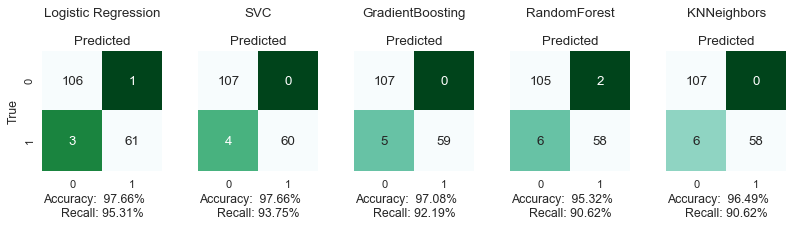

In [62]:
fig, axes = plt.subplots(1,5, figsize=(12,5), dpi=80)
fig.subplots_adjust(wspace=0.3)

for name, col, ax in zip(tuned_names, tuned_test_pred.columns, axes):
    pred = np.round(tuned_test_pred[col])
    confusion_plot(y_test, pred, ax, name)

for tick in axes[0].get_yticklabels():
    tick.set_visible(True)

axes[0].set_ylabel('True');

**Insights from the results:**
- Even though we optimized most models for Recall, recall is still always lower than accuracy. 
- All our models got at least 90% recall - for this data this means 6 malignant tumors not detected
- Our good old Logistic Regression performed the best, **with 95,3% malgiinant tumors detected**. 

We have each model's probabilities. One thing we can do is to **lower the probability threshhold** (50% is the standard). This will make us potentially lose in Accuracy but get a higher Recall. The code below lowers it to 25% (arbitrarly chosen).

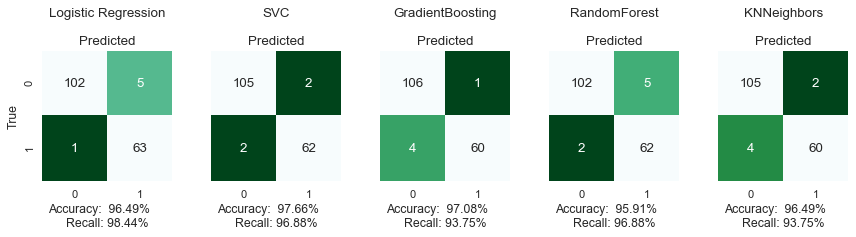

In [63]:
fig, axes = plt.subplots(1,5, figsize=(13,6), dpi=80)
fig.subplots_adjust(wspace=0.3)

for name, col, ax in zip(tuned_names, tuned_test_pred.columns, axes):
    pred = tuned_test_pred[col].apply(lambda x: 1 if x>=0.25 else 0)
    confusion_plot(y_test, pred, ax, name)

for tick in axes[0].get_yticklabels():
    tick.set_visible(True)

axes[0].set_ylabel('True');

All models improved with the lower threshold, now the lowest being 93.75% Recall for KNN.

SVC has an incredible **98.4% Recall and 98.2% Accuracy**! Logistic Regression is right behind with the same Recall and a lower accuracy. Those two were our best models since the beginning (Chapter 4).

## 6.2 - Second-Level Model

After an amazing score on SVC, let's see if our Second-Level Logistic Regression can beat it.

In [64]:
log_snd_lvl.fit(X_train_final, y_train)
second_lvl_pred = pd.Series(log_snd_lvl.predict_proba(X_test_final)[:,1])

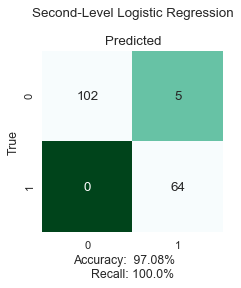

In [65]:
fig, ax = plt.subplots(figsize=(5,3), dpi=80)
confusion_plot(y_test, np.round(second_lvl_pred), ax, 'Second-Level Logistic Regression')
for tick in ax.get_yticklabels():
    tick.set_visible(True)
ax.set_ylabel('True');

Right on target! I did not expect it to perform so well. Don't even need to change the threshold - we got a **100% Recall on test set!!**

That's it for our Test Evaluations.